# A Toxicology Experiment on the Death of Beetles
### by Diana Gerardo Fall 2018
## A Bayesian Approach

**2)** This problem involves Bayesian analysis of the beetle mortality data
from the previous problem.

In [3]:
import numpy
import pandas
import math
import statsmodels.api as statmodels
import scipy.stats as scipy
import seaborn
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [4]:
dat = {'log_dose': [1.6907,1.7242,1.7552,1.7842,1.8113,1.8369,1.8610,1.8839], 
       'beetles': [59,60,62,56,63,59,62,60],
       'num_died': [6,13,18,28,52,53,61,60] }
beetles = pandas.DataFrame(data=dat)

**a)** Consider a Bayesian binomial GLM with a complementary log-log link, i.e., assume that, given $\beta_{1}$ and $\beta_{2}$, the $y_{i}$ are independent from $\text{Bin}(m_{i},\pi(x_{i}))$, i = 1,...,8, where

$$\pi(x)\equiv\pi(x;\beta_{1},\beta_{2})=1-\exp\left\{ -\exp\left(\beta_{1}+\beta_{2}x\right)\right\}$$

Design and implement an MCMC method to sample from the posterior
distribution of $(\beta_{1},\beta_{2})$. Study the effect of the
prior for $(\beta_{1},\beta_{2})$, for example, consider a flat prior
as well as (independent) normal priors.  Under the flat prior, obtain
the posterior distribution for the median lethal dose, $\text{LD}_{50}$,
that is, the dose level at which the probability of response is 0.5.
Finally, plot point and interval estimates for the dose-response curve
$\pi(x)$ (over a grid of values $x$ for log dose).

**Solution:**

In [5]:
cloglog_link= statmodels.families.links.cloglog()

response_variable = beetles['num_died']/beetles['beetles']
beetles['intercept'] = numpy.repeat(1, len(beetles))
covariates = beetles[['intercept','log_dose']]
weights = beetles['beetles']

In [6]:
cloglog_glm = statmodels.GLM(response_variable, covariates,
                             family = statmodels.families.Binomial(link = cloglog_link),
                             var_weights=numpy.asarray(weights))
cloglog_fitted = cloglog_glm.fit()

In [7]:
# Funcitons for M-H process

def burn_chain(burn, samples):
    T = burn
    samples = numpy.delete(samples, obj = range(0,T), axis = 1) 
    
    return samples

def flat_prior(x):
    '''flat prior'''
    return numpy.log(1)

def norm_prior(x, mean, sd):
    '''normal prior'''
    return scipy.norm.logpdf(x[0], mean, sd) + scipy.norm.logpdf(x[1], mean, sd) 

def posterior(beta, x, y, m, f_prior, mean, sd):
    exp_Xb = -1*numpy.exp(beta[0]+beta[1]*x)
    inside_log = 1 - numpy.exp(exp_Xb)
    inside_sum = y * numpy.log(inside_log) + (m-y)*exp_Xb
    
    if f_prior == True:
        values = numpy.exp( flat_prior(beta) + sum(inside_sum) ) 
    else:
        values = numpy.exp( norm_prior(beta, mean, sd) + sum(inside_sum) ) 
        
    return values 

# This M_H_algorithm offers a flat beta prior with f_prior=True. 
# Set f_prior=False to set mean and sd for a normal prior. 
def M_H_algorithm(num_betas, iters, glm_fit, tune_para, y, x, w, f_prior = True, mean = 0, sd = 1):
    burn = int(iters/4)
    iter_beta = numpy.zeros(shape=(num_betas, iters))
    new_beta = numpy.zeros(shape=(num_betas, iters))
    
    J = glm_fit.cov_params()
    d = tune_para   
    
    for i in range(1,iters):
        new_beta[:,i] = scipy.multivariate_normal.rvs(mean = iter_beta[:,i-1], cov = d*J, size = 1)
        numer = posterior(new_beta[:,i], x, y, w, f_prior, mean, sd)
        denom = posterior(iter_beta[:,i-1], x, y, w, f_prior, mean, sd)
        q = numpy.minimum(1, numer/denom )
        
        if numpy.random.uniform(0,1,1) < q:
            iter_beta[:,i] = new_beta[:,i]
        
        else:
            iter_beta[:,i] = iter_beta[:,i-1]
            
            
    return burn_chain(burn, iter_beta)

In [8]:
# plotting helpers

def convergence_plot(arr, color, title, xlab, ylab):
    for i in range(len(title)):
        plt.plot(arr[i,:], color = color)
        plt.title(title[i])
        plt.xlabel(xlab)
        plt.ylabel(ylab[i])
        plt.show()
        
def density_plot(arr, color, title, xlab):
    for i in range(len(title)):
        seaborn.kdeplot(arr[i,:], color = color, shade = True, lw = 1.5
                       ).set(ylabel='Density', xlabel = xlab[i], title = title[i])
        plt.show()
        
def compare_densityplots(arr, color, xlab, title, legend, legend_loc):
    for i in range(len(color)):
        seaborn.kdeplot(arr[i], color = color[i], shade = True, lw = 1.5
                       ).set(xlabel = xlab, title = title)
        
    plt.legend(legend, loc = legend_loc)
    plt.show 

### Prior Analysis

In [9]:
beta_samps_from_standnormprior = M_H_algorithm(num_betas = 2, iters = 10**4, glm_fit = cloglog_fitted, tune_para = 2, 
                           y = beetles["num_died"], x = beetles["log_dose"], w = weights, f_prior = False)

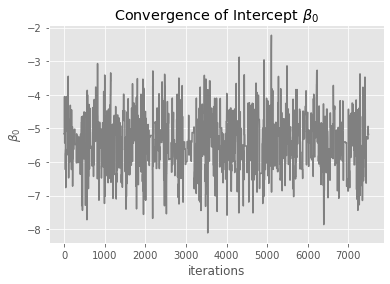

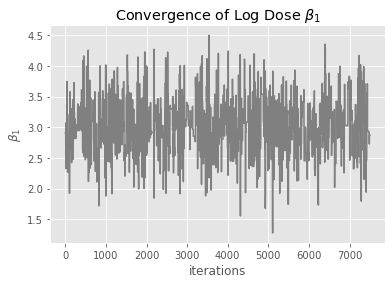

In [13]:
convergence_titles = ["Convergence of Intercept $\u03B2_{0}$", "Convergence of Log Dose $\u03B2_{1}$"]
ylabs = ["$\u03B2_{0}$","$\u03B2_{1}$"]
convergence_plot(beta_samps_from_standnormprior, "grey", convergence_titles, "iterations", ylabs)

In [12]:
beta_samps_from_normprior = M_H_algorithm(num_betas = 2, iters = 10**4, glm_fit = cloglog_fitted, tune_para = 2, 
                                          y = beetles["num_died"], x = beetles["log_dose"], w = weights, f_prior = False,
                                          mean = 5, sd = 20)

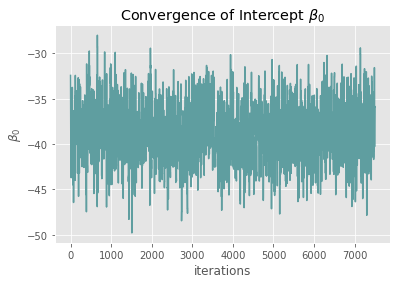

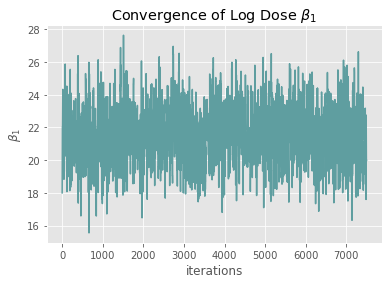

In [14]:
convergence_plot(beta_samps_from_normprior, "cadetblue", convergence_titles, "iterations", ylabs)

In [15]:
beta_samps_from_flatprior = M_H_algorithm(num_betas = 2, iters = 10**4, glm_fit = cloglog_fitted, tune_para = 2, 
                           y = beetles["num_died"], x = beetles["log_dose"], w = weights, f_prior = True)

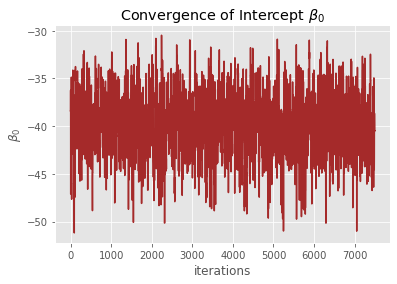

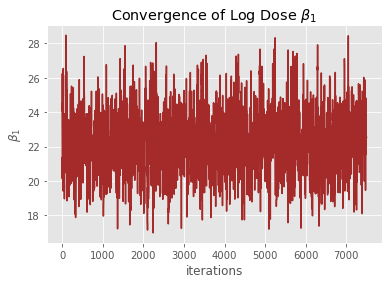

In [16]:
convergence_plot(beta_samps_from_flatprior, "brown", convergence_titles, "iterations", ylabs)

In [17]:
b0_samples = [beta_samps_from_standnormprior[0,:],
           beta_samps_from_normprior[0,:],
           beta_samps_from_flatprior[0,:]] 
b1_samples = [beta_samps_from_standnormprior[1,:],
           beta_samps_from_normprior[1,:],
           beta_samps_from_flatprior[1,:]] 
color_list = ["grey", "cadetblue", "brown"]
prior_legend = ["with prior N(0,1)", "with prior N(5,20)", "with flat prior"]

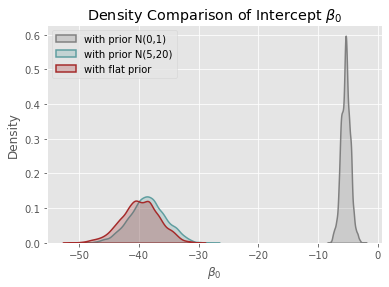

In [18]:
compare_densityplots(b0_samples, color_list, "$\u03B2_{0}$", "Density Comparison of Intercept $\u03B2_{0}$",
                     prior_legend, 2)

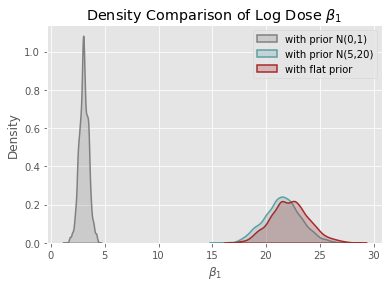

In [19]:
compare_densityplots(b1_samples, color_list, "$\u03B2_{1}$", "Density Comparison of Log Dose $\u03B2_{1}$",
                     prior_legend, 1)

### I choose model with flat pior from here on

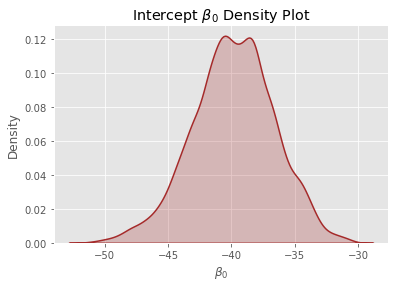

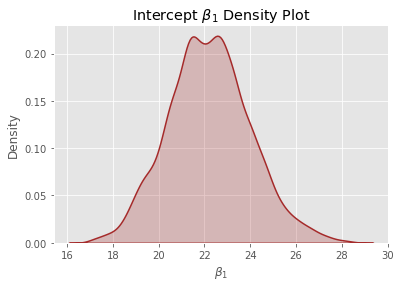

In [20]:
den_titles = ['Intercept $\u03B2_{0}$ Density Plot', 'Intercept $\u03B2_{1}$ Density Plot']
den_xlabs = ["$\u03B2_{0}$","$\u03B2_{1}$"]
density_plot(beta_samps_from_flatprior, "brown", den_titles, den_xlabs)

In [21]:
LD50 = (-0.366513 - beta_samps_from_flatprior[0,:])/beta_samps_from_flatprior[1,:]

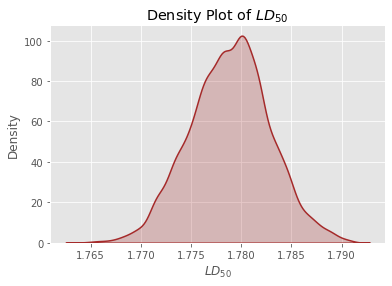

In [22]:
seaborn.kdeplot(LD50, color = "brown", shade = True, lw = 1.5
               ).set(ylabel='Density', xlabel = "${LD}_{50}$", title = "Density Plot of ${LD}_{50}$")
plt.show()

In [23]:
# evaluating pi(x_i), cloglog function, for all x_grid

def cloglog_fucntion(x,b):
    Xb = b[0,:]+b[1,:]*x
    inside = -numpy.exp(Xb)
    val = 1 - numpy.exp(inside)
    
    return val 

def quantile_function(grid, betas, quantiles_to_compute):
    q = numpy.zeros(shape=(len(quantiles_to_compute), len(grid)))
    
    for i in range(100):
        new_pi = cloglog_fucntion(x_grid[i], betas)
        q[:,i] = numpy.quantile(new_pi, quantiles_to_compute)
    
    return q

In [24]:
x_grid = numpy.linspace(start=1.65, stop=1.9, num=100)
quants = [0.025,0.5,0.975]
conf_int = quantile_function(x_grid, beta_samps_from_flatprior, quants) 

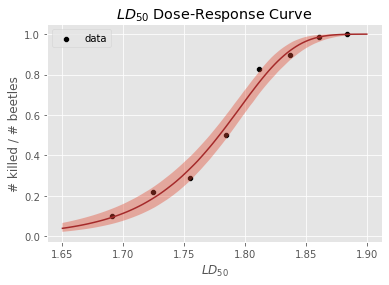

In [38]:
seaborn.lineplot(x = x_grid, y = conf_int[1,:], color = "brown")
seaborn.scatterplot(x = beetles["log_dose"], y = response_variable, color = "black", label = "data"
                   ).set(title = "$LD_{50}$ Dose-Response Curve", ylabel = "# killed / # beetles", xlabel = "$LD_{50}$")
plt.fill_between(x_grid,conf_int[2,:],conf_int[0,:], alpha = .4)

In [42]:
def cll(x,b1,b2):
    xb = b1+b2*x
    inside_exp = -numpy.exp(xb)
    
    return 1-numpy.exp(inside_exp)

In [43]:
cll_residuals = response_variable - cll(beetles['log_dose'],-40,22) #-40 and 20 are posterior mean beta estimates

<function matplotlib.pyplot.show(close=None, block=None)>

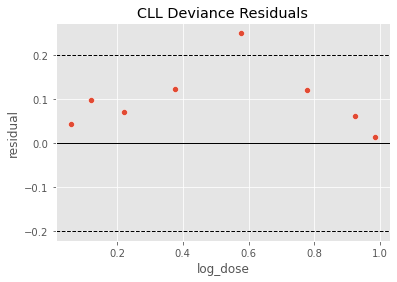

In [41]:
seaborn.scatterplot(x = cll(beetles['log_dose'],-40,22), y = cll_residuals
                   ).set(ylabel= 'residual', title='CLL Deviance Residuals')
plt.axhline(0.2, color = 'black', ls = '--', lw = 1)
plt.axhline(0, color = 'black', ls = '-', lw = 1)
plt.axhline(-0.2, color = 'black', ls = '--', lw = 1)
plt.show